<a target="_blank" href="https://colab.research.google.com/github/taobrienlbl/advanced_earth_science_data_analysis/blob/spring_2023_iub/lessons/06_advanced_plotting/06_workalong01_advanced_plotting.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Advanced Plotting Workalong

In this workalong notebook, we will explore some more advanced plotting techniques, including:

* multipanel plotting
* axis sharing
* adding text to panels
* adding a common colorbar
* saving figures

This will be accompanied by a lecture on the conceptual model underlying `matplotlib`

# Loading data

As a first step, we'll load some temperature data, similar to last week.

In [1]:
""" Download the nc data file """

# set the year we want to download
year = 2021 
# set the URL for the NCEP/DOE Reanalysis 2 data file
url = f"https://psl.noaa.gov/thredds/fileServer/Datasets/ncep.reanalysis2/gaussian_grid/air.2m.gauss.{year}.nc"

# set the name of the file we want to download to
output_file = f"air.2m.gauss.{year}.nc"

# download the data file
# NOTE: the use of ! at the beginning of the line indicates that this is a shell command, not python code -- though it does use some python code.  How, why?
# check first if the file exists; don't re-download if it does
import os
if not os.path.exists(output_file):
    ! curl --output {output_file} {url}


In [2]:
""" Read in the data """
import xarray as xr

# open the dataset using xarray
temp_ds = xr.open_dataset(output_file, chunks = -1)
# examine the xarray dataset type
print(type(temp_ds))
temp_ds

<class 'xarray.core.dataset.Dataset'>


<xarray.Dataset>
Dimensions:    (level: 1, lat: 94, lon: 192, time: 1460, nbnds: 2)
Coordinates:
  * level      (level) float32 2.0
  * lat        (lat) float32 88.54 86.65 84.75 82.85 ... -84.75 -86.65 -88.54
  * lon        (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * time       (time) datetime64[ns] 2021-01-01 ... 2021-12-31T18:00:00
Dimensions without coordinates: nbnds
Data variables:
    air        (time, level, lat, lon) float32 dask.array<chunksize=(1460, 1, 94, 192), meta=np.ndarray>
    time_bnds  (time, nbnds) float64 dask.array<chunksize=(1460, 2), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.0
    title:          4x Daily NCEP/DOE Reanalysis 2
    comments:       Data is from \nNCEP/DOE AMIP-II Reanalysis (Reanalysis-2)...
    platform:       Model
    source:         NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Model
    institution:    National Centers for Environmental Prediction
    dataset_title:  NCEP-DOE AMIP-II Reanalysis
    References:     https://www.psl.noaa.gov/data/gridded/data.ncep.reanalysi...
    source_url:     http://www.cpc.ncep.noaa.gov/products/wesley/reanalysis2/
    history:        created 2021/02 by NOAA/ESRL/PSD\nConverted to chunked, d...

In [3]:
""" Calculate the hottest temperature recorded in each season. """

# xarray is built on top of pandas, so we can use groupby for this
season_groups = temp_ds.groupby('time.season')
# examine the group type
print(type(season_groups))
season_groups

<class 'xarray.core.groupby.DatasetGroupBy'>


DatasetGroupBy, grouped over 'season'
4 groups with labels 'DJF', 'JJA', 'MAM', 'SON'.

In [4]:
# calculate the max in each season
season_max_temp = season_groups.max()
# examine the output dataset type
print(type(season_max_temp))
season_max_temp

<class 'xarray.core.dataset.Dataset'>


<xarray.Dataset>
Dimensions:    (level: 1, lat: 94, lon: 192, season: 4, nbnds: 2)
Coordinates:
  * level      (level) float32 2.0
  * lat        (lat) float32 88.54 86.65 84.75 82.85 ... -84.75 -86.65 -88.54
  * lon        (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * season     (season) object 'DJF' 'JJA' 'MAM' 'SON'
Dimensions without coordinates: nbnds
Data variables:
    air        (season, level, lat, lon) float32 dask.array<chunksize=(1, 1, 94, 192), meta=np.ndarray>
    time_bnds  (season, nbnds) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.0
    title:          4x Daily NCEP/DOE Reanalysis 2
    comments:       Data is from \nNCEP/DOE AMIP-II Reanalysis (Reanalysis-2)...
    platform:       Model
    source:         NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Model
    institution:    National Centers for Environmental Prediction
    dataset_title:  NCEP-DOE AMIP-II Reanalysis
    References:     https://www.psl.noaa.gov/data/gridded/data.ncep.reanalysi...
    source_url:     http://www.cpc.ncep.noaa.gov/products/wesley/reanalysis2/
    history:        created 2021/02 by NOAA/ESRL/PSD\nConverted to chunked, d...

In [5]:
# extract temperature (and also use 'squeeze' to remove the pesky single-item level dimension)
max_temp_xr = season_max_temp['air'].squeeze()
# examine the DataArray type
print(type(max_temp_xr))
max_temp_xr

<class 'xarray.core.dataarray.DataArray'>


<xarray.DataArray 'air' (season: 4, lat: 94, lon: 192)>
dask.array<getitem, shape=(4, 94, 192), dtype=float32, chunksize=(1, 94, 192), chunktype=numpy.ndarray>
Coordinates:
    level    float32 2.0
  * lat      (lat) float32 88.54 86.65 84.75 82.85 ... -84.75 -86.65 -88.54
  * lon      (lon) float32 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes: (12/13)
    long_name:      6-Hourly Forecast of Air temperature at 2 m
    units:          degK
    precision:      2
    GRIB_id:        11
    GRIB_name:      TMP
    var_desc:       Air temperature
    ...             ...
    level_desc:     2 m
    statistic:      Mean
    parent_stat:    Individual Obs
    standard_name:  air_temperature
    valid_range:    [120. 430.]
    actual_range:   [182.33 327.4 ]

In [6]:
""" Pull out season, lat, and lon arrays for plotting. """
# Note: these variables are from the DataArray, not Dataset, so there is no .values in the end
seasons = max_temp_xr.season
lat = max_temp_xr.lat
lon = max_temp_xr.lon

# Multipanel plotting

The simplest approach to making a multipanel plot with `matplotlib` is to use `plt.subplots()`

In [7]:
""" import necessary libraries for plotting """
import matplotlib.pyplot as plt

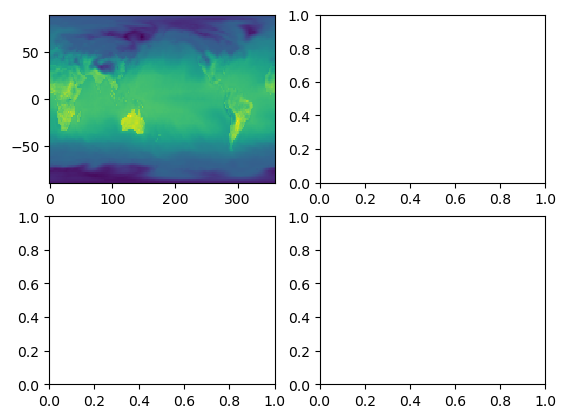

In [8]:
""" Generate a multipanel plot of seasonal max temperature, but only fill in the top left panel. """

# generate a 2x2 panel figure
fig, axs2d = plt.subplots(2,2)
# create a vector of plots (first index is the top left)
axs = axs2d.ravel()
# select the panel
ax = axs[0]
# select the season
season = 'DJF'

# select the data for this season
max_temp_this_season = max_temp_xr.sel(season=season)
# plot temperature using pcolormesh (each value in the array is assigned a color)
ax.pcolormesh(lon, lat, max_temp_this_season)

plt.show()

## A sidenote about `zip`

If we want to loop over two things that have the same length, we can use the `zip()` function to loop over corresponding pairs of items in each list.

Say we have `list_1 = [0,1,2,3]` and `list_2 = ['i', 'j', 'k', 'l']`.  Then we can iterate over both using zip, e.g.,:

```
for x1, x2 in zip(list_1, list_2):
    print(x1,x2)
```

Try it below!

In [9]:
""" Test the `zip` function """
list_1 = [0, 1, 2, 3]
list_2 = ['i', 'j', 'k', 'l']

for x1, x2 in zip(list_1, list_2):
    print(x1, x2)

0 i
1 j
2 k
3 l


In [10]:
# x1, x2 are not tuple above, unless in parentheses
for (x1, x2) in zip(list_1, list_2):
    print((x1, x2))

(0, 'i')
(1, 'j')
(2, 'k')
(3, 'l')


We can use this to loop over the four seasons in `season` and the four plot panels in `axs`.

## Looping over panels

Use the code above and incorporate a for-loop with `zip` to plot all four seasons.

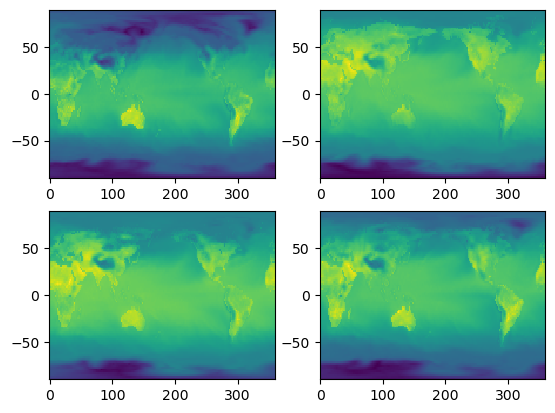

In [11]:
""" Plot data for each season using a for loop and zip"""

fig, axs2d = plt.subplots(2,2)
axs = axs2d.ravel()

for ax, season in zip(axs, seasons):
    max_temp_this_season = max_temp_xr.sel(season=season)
    ax.pcolormesh(lon, lat, max_temp_this_season)

plt.show()

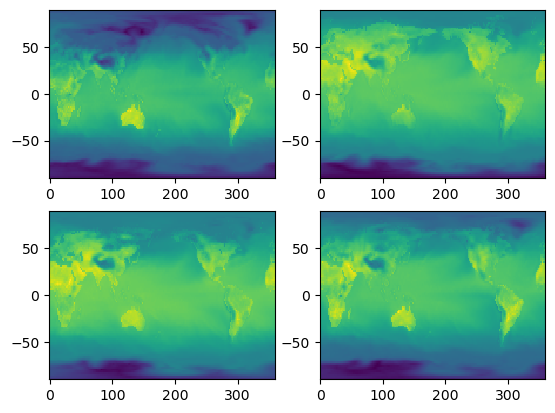

In [12]:
""" Alternatively, plot data for each season using a for loop and enumerate """

fig, axs2d = plt.subplots(2,2)
axs = axs2d.ravel()

for i, season in enumerate(seasons):
    max_temp_this_season = max_temp_xr.sel(season=season)
    axs[i].pcolormesh(lon, lat, max_temp_this_season)

plt.show()

Great, now we have a four-panel plot.  But there are some things that I don't like about it:

1. It lacks a colorbar
2. There are no axis labels
3. I don't like the aspect ratio
4. The fonts look ugly to me
5. There's no need to repeat tick labels for each panel
6. There are no panel labels (e.g., panel '(a)')
7. This colormap is way over-used and probably isn't intuitive for temperature
8. It isn't obvious what season each panel corresponds to

We'll walk through these in action below.

In [13]:
""" Force dask to compute the max temperature for each season (saves time when repeating plots)"""

# force computation of the max temperature
max_temp_xr.load()

<xarray.DataArray 'air' (season: 4, lat: 94, lon: 192)>
array([[[268.97998, 269.01   , 269.03   , ..., 268.88998, 268.91998,
         268.96   ],
        [271.03   , 271.24   , 271.41   , ..., 270.53998, 270.50998,
         270.78998],
        [273.93   , 274.     , 274.03   , ..., 273.26   , 273.6    ,
         273.81   ],
        ...,
        [259.98   , 259.79   , 259.62   , ..., 260.59   , 260.37   ,
         260.16998],
        [259.29   , 259.19   , 259.09   , ..., 259.6    , 259.5    ,
         259.4    ],
        [257.61   , 257.54   , 257.47   , ..., 257.82   , 257.75   ,
         257.68   ]],

       [[274.94   , 274.96   , 274.97   , ..., 274.88998, 274.9    ,
         274.91998],
        [274.87   , 274.86   , 274.84   , ..., 274.88998, 274.88   ,
         274.88   ],
        [275.08   , 275.06   , 275.08   , ..., 275.09998, 275.09   ,
         275.06   ],
...
        [255.26999, 254.98   , 254.68   , ..., 256.13   , 255.84999,
         255.56   ],
        [252.84   , 252.65   , 252.45   , ..., 253.39   , 253.20999,
         253.03   ],
        [248.85   , 248.79   , 248.73   , ..., 248.93   , 248.95   ,
         248.9    ]],

       [[273.63   , 273.48   , 273.49   , ..., 273.78   , 273.78   ,
         273.71   ],
        [273.81   , 273.8    , 273.8    , ..., 273.82   , 273.81   ,
         273.81   ],
        [274.07   , 274.06   , 274.06   , ..., 274.11002, 274.09   ,
         274.08   ],
        ...,
        [255.95999, 255.84   , 255.73   , ..., 257.22   , 256.8    ,
         256.37   ],
        [255.82999, 255.79999, 255.76999, ..., 256.37   , 256.08002,
         255.87   ],
        [253.54999, 253.51   , 253.54999, ..., 253.88998, 253.76999,
         253.65999]]], dtype=float32)
Coordinates:
    level    float32 2.0
  * lat      (lat) float32 88.54 86.65 84.75 82.85 ... -84.75 -86.65 -88.54
  * lon      (lon) float32 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes: (12/13)
    long_name:      6-Hourly Forecast of Air temperature at 2 m
    units:          degK
    precision:      2
    GRIB_id:        11
    GRIB_name:      TMP
    var_desc:       Air temperature
    ...             ...
    level_desc:     2 m
    statistic:      Mean
    parent_stat:    Individual Obs
    standard_name:  air_temperature
    valid_range:    [120. 430.]
    actual_range:   [182.33 327.4 ]

In [14]:
""" import more libraries """
import cmocean   # for better colormaps
import numpy as np

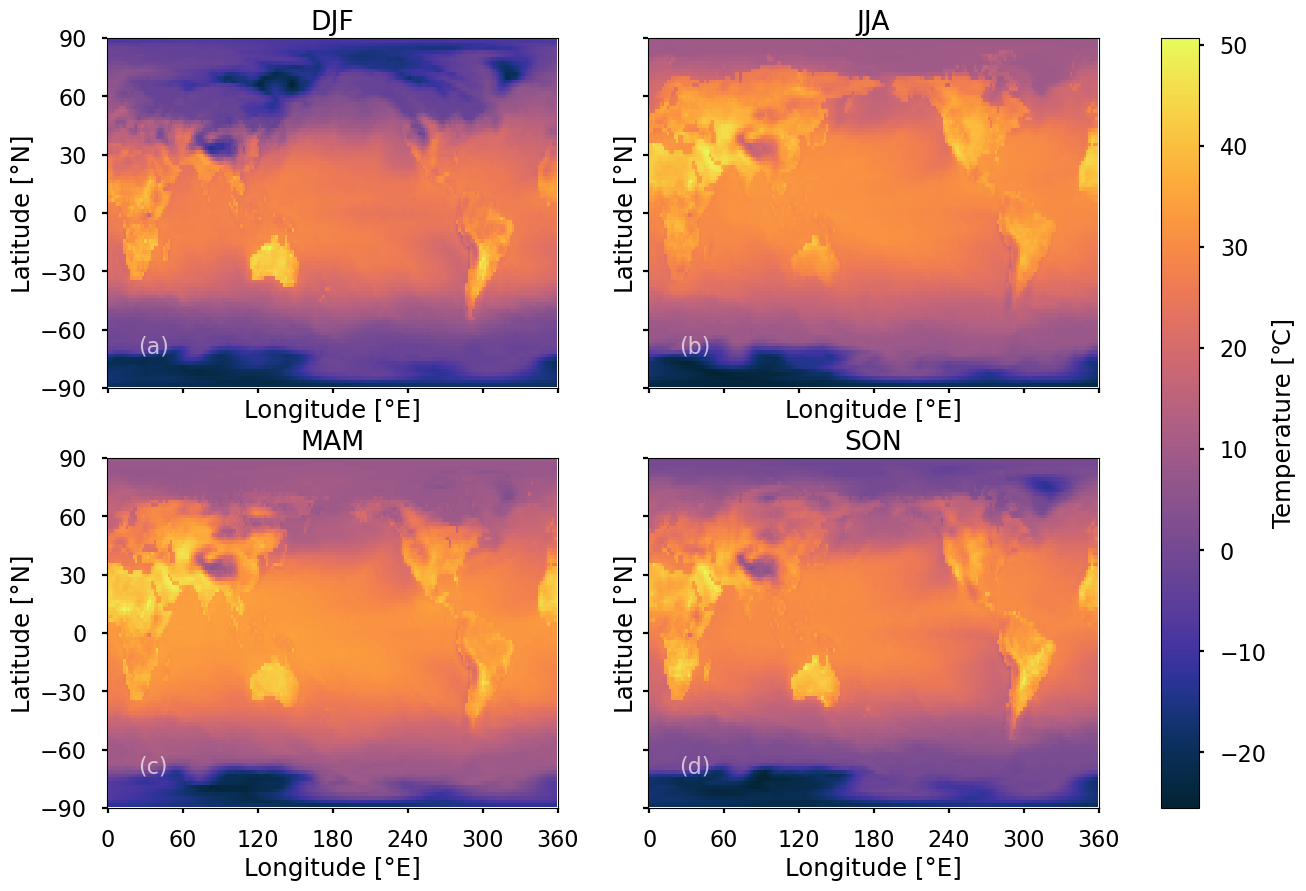

In [15]:
""" Make the plot look nice. """

# set the plot style
plt.style.use('seaborn-v0_8-poster')

# set the colormap
cmap = cmocean.cm.thermal

# create the multipanel plot
fig, axs2d = plt.subplots(2,2, figsize=(16,10), sharex=True, sharey=True)
axs = axs2d.ravel()

# set panel labels
labels = ['(a)', '(b)', '(c)', '(d)']

for ax, season, label in zip(axs, seasons, labels):
    max_temp_this_season = max_temp_xr.sel(season=season) - 273.15
    cplt = ax.pcolormesh(lon, lat, max_temp_this_season, cmap=cmap)

    ax.set_title(str(season.values))
    ax.text(0.07, 0.1, label, transform=ax.transAxes, fontsize=16, color='#FFFFFFAA')
    
    ax.set_yticks(np.arange(-90, 91, 30))
    ax.set_ylabel("Latitude [°N]")
    ax.set_xticks(np.arange(0, 361, 60))
    ax.set_xlabel("Longitude [°E]")
    

fig.colorbar(cplt, ax=axs, label="Temperature [℃]")
#plt.tight_layout()
plt.savefig("season_max_temp", dpi=300, bbox_inches='tight')
plt.show()

*Add a caption here*  
**Caption**: Maximum 2-meter air temperature in each season of the year 2021